# clustering calcium signals
Group of Joel Bauer, Annette Loidolt, Caroline Weiand and Uwe Lewin
https://docs.google.com/document/d/18pjHYOuAd8yLlwQOMr20EXVkvPd2xPTn99PT9L2-_yo/edit#

![title](bauerLGN.png)


In [5]:
import tifffile 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as ipw
from rastermap import Rastermap as rm
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram


## load data

In [6]:
filepath = Path("../../data/processed/suite2p/plane0")
filepath

WindowsPath('../../data/processed/suite2p/plane0')

In [7]:
F = np.load(filepath.joinpath('F.npy'), allow_pickle=True)
Fneu = np.load(filepath.joinpath('Fneu.npy'), allow_pickle=True)
deconv = np.load(filepath.joinpath('spks.npy'), allow_pickle=True)
stat = np.load(filepath.joinpath('stat.npy'), allow_pickle=True)
ops = np.load(filepath.joinpath('ops.npy'), allow_pickle=True).item()
iscell = np.load(filepath.joinpath('iscell.npy'), allow_pickle=True)

## Rastaplot model and visualization

In [8]:
model = rm(n_components=1, n_X=30, nPC=200, init='pca')

In [9]:
deconvcells = deconv[np.where(iscell[:,0] == 1)]
deconvcells.shape

(109, 2250)

In [10]:
deconvnotcells = deconv[np.where(iscell[:,0] == 0)]
deconvnotcells.shape

(338, 2250)

## plot cells sorted vs. unsorted (iscell == 1)

In [11]:
model.fit(deconvcells)

nmin 109
0.0019981861114501953
0.06196403503417969
0.06596231460571289
0.06796002388000488
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
1.53s     0        0.0360      2
1.57s    10        0.1178      4
1.60s    20        0.1977      8
1.63s    30        0.3580      18
1.67s    40        0.4834      28
1.70s    50        0.4836      28
1.73s   final      0.4836
1.74s upsampled    0.4836


Text(0.5, 1.0, 'cells sorted')

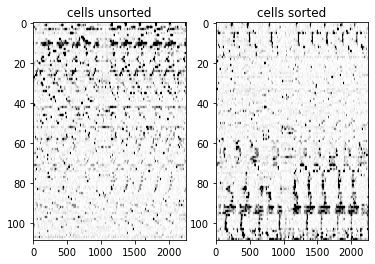

In [12]:
plt.subplot(1,2,1)
plt.imshow(deconvcells,vmin =0, vmax =200, cmap = 'gray_r', aspect = 'auto')
plt.title('cells unsorted')
plt.subplot(1,2,2)
plt.imshow(deconvcells[model.isort, :],vmin =0, vmax =200, cmap = 'gray_r', aspect = 'auto')
plt.title('cells sorted')

## Plot non-cells sorted vs. unsorted (iscell==0)

nmin 109
0.0019989013671875
0.24186325073242188
0.2508571147918701
0.253856897354126
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.00s     0        0.0229      2
0.12s    10        0.0868      4
0.18s    20        0.1478      8
0.21s    30        0.2571      18
0.28s    40        0.3452      28
0.33s    50        0.3479      28
0.37s   final      0.3479
0.38s upsampled    0.3479


Text(0.5, 1.0, 'non-cells sorted')

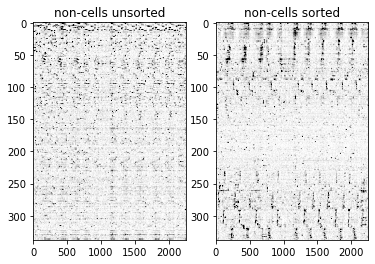

In [13]:
model.fit(deconvnotcells)
plt.subplot(1,2,1)
plt.imshow(deconvnotcells,vmin =0, vmax =200, cmap = 'gray_r', aspect = 'auto')
plt.title('non-cells unsorted')
plt.subplot(1,2,2)
plt.imshow(deconvnotcells[model.isort, :],vmin =0, vmax =200, cmap = 'gray_r', aspect = 'auto')
plt.title('non-cells sorted')

 ## Kids building their own Rastamap

## correlation matrix of the cell activity (iscell == 1)

In [14]:
corrmat = np.corrcoef(deconvcells)
corrmat.shape

(109, 109)

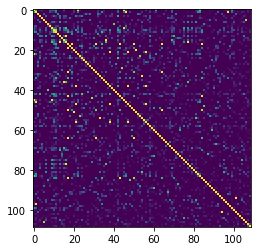

In [15]:
plt.imshow(corrmat, vmin= 0, vmax = 0.3)

## Kmeans clustering

In [16]:
clusters = cluster.KMeans(5).fit(corrmat)
labels = clusters.labels_

## plot the deconvolved signal for each cluster seperately

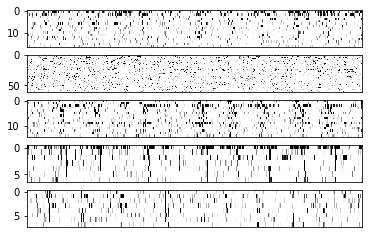

In [17]:
for i in range(1,len(np.unique(labels))+1):
    plt.subplot(len(np.unique(labels)), 1, i)
    plt.imshow(deconvcells[np.where(labels == i-1)], vmin = 0, vmax = 200, cmap = 'gray_r',        aspect='auto',interpolation = 'none')
    plt.xticks(ticks=[])

## Ward clustering

In [18]:
clusters_ward = cluster.AgglomerativeClustering(n_clusters = 5,linkage='ward')
labels_ward = clusters_ward.fit(corrmat).labels_


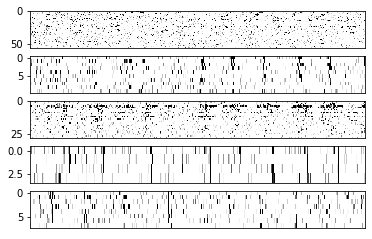

In [19]:
for i in range(1,len(np.unique(labels_ward))+1):
    plt.subplot(len(np.unique(labels_ward)), 1, i)
    plt.imshow(deconvcells[np.where(labels_ward == i-1)], vmin = 0, vmax = 200, cmap = 'gray_r',        aspect='auto',interpolation = 'none')
    plt.xticks(ticks=[])


## plot a dendrogram of the agglomerative ward linkage clustering

In [20]:
clusters_ward = cluster.AgglomerativeClustering(n_clusters = int(sum(iscell[:,0])),linkage='ward',compute_distances=True)
wardcluster = clusters_ward.fit(corrmat)

In [21]:
child = wardcluster.children_
distance = wardcluster.distances_
labels1000 = wardcluster.labels_

## def function to plot dendrogram 
(https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [22]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


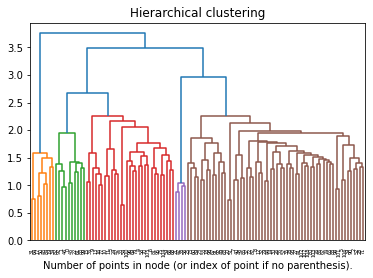

In [23]:
plot_dendrogram(wardcluster)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.title('Hierarchical clustering')
plt.show()

([], [])

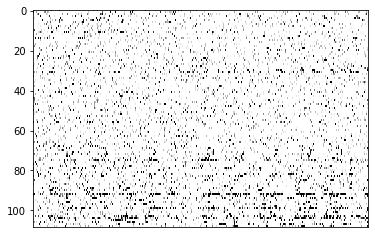

In [24]:
plt.imshow(deconvcells[labels1000], vmin = 0, vmax = 200, cmap = 'gray_r',aspect='auto',interpolation = 'none')
plt.xticks(ticks=[])
